# Preâmbulo

Imports, funções, downloads e instalação do Pytorch.

In [0]:
 # Basic imports.
import os
import time
import numpy as np
import torch

from torch import nn
from torch import optim
from torch.nn import functional as F

from torch.utils.data import DataLoader
from torch.utils import data
from torch.backends import cudnn

from torchvision import models
from torchvision import datasets
from torchvision import transforms

from skimage import io

from sklearn import metrics

from matplotlib import pyplot as plt

%matplotlib inline

cudnn.benchmark = True

In [13]:
# Setting predefined arguments.
args = {
    'epoch_num': 50,      # Number of epochs.
    'lr': 5e-4,           # Learning rate.
    'weight_decay': 1e-5, # L2 penalty.
    'num_workers': 3,     # Number of workers on data loader.
    'batch_size': 100,    # Mini-batch size.
    'print_freq': 1,      # Printing frequency.
    'lambda_var': 1.0,    # Variational multiplier in loss.
    'num_gauss': 20,      # Number of gaussians in bottleneck of VAE.
    'num_samples': 8,     # Number of samples to be generated in evaluation.
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cuda


# Carregando o  MNIST

In [14]:
# Root directory for the dataset (to be downloaded).
root = './'

# Transformations over the dataset.
data_transforms = transforms.Compose([
    transforms.ToTensor()
])

# Setting datasets and dataloaders.
train_set = datasets.MNIST(root,
                           train=True,
                           download=True,
                           transform=data_transforms)
test_set = datasets.MNIST(root,
                          train=False,
                          download=False,
                          transform=data_transforms)

# Setting dataloaders.
train_loader = DataLoader(train_set,
                          args['batch_size'],
                          num_workers=args['num_workers'],
                          shuffle=True)
test_loader = DataLoader(test_set,
                         args['batch_size'],
                         num_workers=args['num_workers'],
                         shuffle=False)

# Printing training and testing dataset sizes.
print('Size of training set: ' + str(len(train_set)) + ' samples')
print('Size of test set: ' + str(len(test_set)) + ' samples')

Size of training set: 60000 samples
Size of test set: 10000 samples


# AutoEncoder Variacional

Idealmente codificações compactas de dados redundantes (i.e. imagens) deveriam produzir representações latentes que fossem independentes uma da outra num nível semântico. Ou seja, cada bin num feature map latente $z$ de um autoencoder deveria codificar o máximo de informação possível (i.e. linhas verticais que compõem um '1', '7' ou '9'; ou círculos que compõem um '6', '8' ou '0') para a reconstrução dos dígitos do MNIST, por exemplo. A [inferência variacional](https://www.cs.princeton.edu/courses/archive/fall11/cos597C/lectures/variational-inference-i.pdf) provém uma forma mais simples de computarmos o Maximum a Posteriori (MAP) de distribuições estatísticas complexas como as que estamos lidando.

![VAE Features](https://www.dropbox.com/s/fkvdn69tkh7tm1p/vae_gaussian.png?dl=1)

Se tivermos controle sobre representações latentes em $z$ que codificam features de algo nível semântico, podemos utilizar o Decoder de um AE para geração de novas amostras. Usando o Encoder de um AE tradicional, conseguimos partir do vetor de entrada $x$ e chegar no vetor latente $z \sim q(z ∣ x)$. Porém, como não temos controle sobre a distribuição $q$, não é possível fazer o caminho inverso, ou seja, a partir de $z$ modelar $x \sim p(x | z)$. Essa é a motivação para um Variational AutoEncoder (VAE).

![VAE x->z](https://www.dropbox.com/s/o8daaskdrhfav7r/VAE_Enc.png?dl=1)

![VAE z->x](https://www.dropbox.com/s/wqi8nsak84i11mi/VAE_Dec.png?dl=1)

Para podermos ter um controle maior sobre distribuição de cada bin de $z$, adicionamos uma "regularização" $\mathcal{L}_{KL}(\mu, \sigma)$ à loss de regressão $\mathcal{L}_{r}(x, \hat{x})$ de um AE tradicional. Percebe-se que $\mu$ e $\sigma$ devem codificar a média e o desvio padrão de distribuições gaussianas multivariadas, o que permite realizarmos uma amostragem dessa distribuição. Não podemos, porém, backpropagar de nós na nossa rede que realizem amostragem de uma distribuição. Portanto, precisamos do truque da reparametrização mostrado abaixo para backpropagarmos apenas por $\mu$ e $\sigma$, mas não por $\epsilon$.

![Reparametrization](https://jaan.io/images/reparametrization.png)

Assim, a arquitetura final de um VAE segue o esquema a seguir composto no bottleneck por um vetor $\mu$, um vetor $\sigma$ e um vetor $\epsilon$, que formam a representação latente $z = \mu + \sigma * \epsilon$.

![VAE training](https://www.dropbox.com/s/719vkfnfsobimmd/VAE_training.png?dl=1)

A ideia é que cada gaussiana codifique uma característica de alto nível nos dados, permitindo que utilizemos o modelo generativo do VAE para, de fato, gerar amostras novas verossímeis no domínio dos dados de treino.

![VAE gif](https://media.giphy.com/media/26ufgj5LH3YKO1Zlu/giphy.gif)

Para entender mais sobre "disentangled representations", ler o paper original do [VAE](https://arxiv.org/abs/1312.6114), o [$\beta$-VAE](https://openreview.net/references/pdf?id=Sy2fzU9gl) e o paper que propõe as [InfoGANs](https://arxiv.org/pdf/1606.03657.pdf):

# Atividade Prática: Implementando o VAE

1.   Defina a arquitetura do VAE. O Encoder da rede será composto de duas camadas precedendo as camadas $\mu$ e $\sigma$, de forma que $\mu$ e $\sigma$ recebam as mesmas entradas e se combinem como explicado a cima para formar o vetor latente $z$. A dimensionalidade de entrada dos dados ($784$) deve ser diminuída gradativamente até chegar no bottleneck, assim como nosso primeiro exemplo do AE Linear. Ambas camadas $\mu$ e $\sigma$ devem receber dados de dimensionalidade alta e codificá-los para uma saída dada pela variável *n_gaus*. Não é preciso criar uma camada explícita para $\epsilon$, já que ele só representa a amostragem de uma distribuição gaussiana ([torch.randn()](https://pytorch.org/docs/stable/torch.html#torch.randn));
2.   Complete a implementação dos métodos *encode()* que encapsula o forward pelo Encoder, *reparameterize()* que amostra $\epsilon$ e realiza o truque da reparametrização e *decode()* que faz o forward de $z$ pelo Decoder da rede, o qual deve ser simétrico ao encoder, ou seja, receber *n_gaus* features vindos de $z$ e gradativamente aumentar os features para recuperar $784$ features. Dica: na função *reparameterize()*;
3.   Defina a loss composta do VAE na função *variational_loss()*. Essa função deve retornar o componente $\mathcal{L}_{r}$ da loss (já feito usando a BCE) e o componente $\mathcal{L}_{KL}$. Dica: ver o Apêndice B do paper dos [VAEs](https://arxiv.org/pdf/1312.6114.pdf) para a fórmula de $\mathcal{L}_{KL}$;
4.   Na função *generate_2d()* altere as dimensões da tupla *dim_linspace* até achar um par de dimensões que influencie os novos samples em alto nível semântico.

# Definindo a arquitetura

In [15]:
# AutoEncoder implementation.
class VariationalAutoEncoder(nn.Module):
    
    def __init__(self, n_gaus):

        super(VariationalAutoEncoder, self).__init__()
        
        self.n_gaus = n_gaus
        
        # TO DO: Encoder.
        self.enc_1 = nn.Sequential(
            nn.Linear(784, 400),
            nn.ReLU(),
        )
        self.enc_2 = nn.Sequential(
            nn.Linear(400, 200),
            nn.ReLU(),
        )
        # TO DO: Layers mu and sigma.
        self.enc_mu = nn.Linear(200, n_gaus) # Mean vector.
        self.enc_sigma = nn.Linear(200, n_gaus) # Std vector.
        
        # TO DO: Decoder.
        self.decoder = nn.Sequential(
            nn.Linear(n_gaus, 200),
            nn.ReLU(),
            nn.Linear(200, 400),
            nn.ReLU(),
            nn.Linear(400, 784),
            nn.Sigmoid()
        )
        
        self.initialize_weights()
        
    # TO DO: Encoding function.
    def encode(self, x):
        
        out_1 = self.enc_1(x)
        out_2 = self.enc_2(out_1)
        
        out_mu = self.enc_mu(out_2) # Mean vector.
        out_sigma = self.enc_sigma(out_2) # Std vector.
        
        return out_mu, out_sigma
        
    # TO DO: Decoding function.
    def decode(self, z):
        
        out = self.decoder(z)
        
        return out
               
    # TO DO: Reparametrization function. 
    def reparameterize(self, mu, logvar):
        
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + (eps * std)
    
    # Function for randomly initializing weights.
    def initialize_weights(self):
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        
        mu, logvar = self.encode(x)
        
        z = self.reparameterize(mu, logvar)
        
        dec = self.decode(z)
        
        return dec, mu, logvar

# Instantiating architecture.
net = VariationalAutoEncoder(args['num_gauss']).to(args['device'])

# Printing architecture.
print(net)

VariationalAutoEncoder(
  (enc_1): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): ReLU()
  )
  (enc_2): Sequential(
    (0): Linear(in_features=400, out_features=200, bias=True)
    (1): ReLU()
  )
  (enc_mu): Linear(in_features=200, out_features=20, bias=True)
  (enc_sigma): Linear(in_features=200, out_features=20, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=400, bias=True)
    (3): ReLU()
    (4): Linear(in_features=400, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


# Definindo o otimizador

In [0]:
optimizer = optim.Adam(net.parameters(),
                       lr=args['lr'],
                       weight_decay=args['weight_decay'])

# Definindo a loss

In [0]:
# TO DO: Reconstruction + KL losses summed over all elements and batch.
def variational_loss(recon_x, x, mu, logvar):
    
    # Reconstruction loss using BCE
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # TO DO: KL Divergence loss.
    # See Appendix B from VAE paper:
    #     https://arxiv.org/pdf/1312.6114.pdf.
    # See Pytorch's implementation of VAEs:
    #     https://github.com/pytorch/examples/blob/master/vae/main.py.
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE, KLD

# Criando funções para Treino e Teste

In [0]:
# Training procedure.
def train(train_loader, net, optimizer, epoch):

    tic = time.time()
    
    # Setting network for training mode.
    net.train()

    # Lists for losses and metrics.
    train_loss = []
    
    # Iterating over batches.
    for i, batch_data in enumerate(train_loader):

        # Obtaining images and labels for batch.
        inps, labs = batch_data
        
        # Casting to cuda variables and reshaping.
        inps = inps.view(inps.size(0), -1).to(args['device'])
        
        # Clears the gradients of optimizer.
        optimizer.zero_grad()

        # Forwarding.
        outs, mu, logvar = net(inps)

        # TO DO Computing total loss.
        loss_bce, loss_kld = variational_loss(outs, inps, mu, logvar)
        
        loss = loss_bce + args['lambda_var'] * loss_kld

        # Computing backpropagation.
        loss.backward()
        optimizer.step()
        
        # Updating lists.
        train_loss.append((loss_bce.data.item(),
                           args['lambda_var'] * loss_kld.data.item(),
                           loss.data.item()))
    
    toc = time.time()
    
    train_loss = np.asarray(train_loss)
    
    # Printing training epoch loss and metrics.
    print('-------------------------------------------------------------------')
    print('[epoch %d], [train bce loss %.4f +/- %.4f], [train kld loss %.4f +/- %.4f], [training time %.2f]' % (
        epoch, train_loss[:,0].mean(), train_loss[:,0].std(), train_loss[:,1].mean(), train_loss[:,1].std(), (toc - tic)))
    print('-------------------------------------------------------------------')
    

In [0]:
# Testing procedure.
def test(test_loader, net, epoch):

    tic = time.time()
    
    # Setting network for evaluation mode.
    net.eval()

    # Lists for losses and metrics.
    test_loss = []
    
    # Iterating over batches.
    for i, batch_data in enumerate(test_loader):

        # Obtaining images and labels for batch.
        inps, labs = batch_data

        # Casting to cuda variables and reshaping.
        inps = inps.view(inps.size(0), -1).to(args['device'])

        # Forwarding.
        outs, mu, logvar = net(inps)

        # Computing loss.
        loss_bce, loss_kld = variational_loss(outs, inps, mu, logvar)
        
        loss = loss_bce + args['lambda_var'] * loss_kld
        
        # Updating lists.
        test_loss.append((loss_bce.data.item(),
                          args['lambda_var'] * loss_kld.data.item(),
                          loss.data.item()))
        
        if i == 0 and epoch % args['print_freq'] == 0:
            
            fig, ax = plt.subplots(2, 8, figsize=(16, 4))
        
        if i < 8 and epoch % args['print_freq'] == 0:
            
            ax[0, i].imshow(inps.view(inps.size(0), 28, 28)[0].detach().cpu().numpy())
            ax[0, i].set_yticks([])
            ax[0, i].set_xticks([])
            ax[0, i].set_title('Image ' + str(i + 1))
            
            ax[1, i].imshow(outs.view(inps.size(0), 28, 28)[0].detach().cpu().numpy())
            ax[1, i].set_yticks([])
            ax[1, i].set_xticks([])
            ax[1, i].set_title('Reconstructed ' + str(i + 1))
            
        if i == 8 and epoch % args['print_freq'] == 0:
            
            plt.show()
    
    toc = time.time()
    
    test_loss = np.asarray(test_loss)
    
    # Printing training epoch loss and metrics.
    print('-------------------------------------------------------------------')
    print('[epoch %d], [test bce loss %.4f +/- %.4f], [test kld loss %.4f +/- %.4f], [testing time %.2f]' % (
        epoch, test_loss[:,0].mean(), test_loss[:,0].std(), test_loss[:,1].mean(), test_loss[:,1].std(), (toc - tic)))
    print('-------------------------------------------------------------------')

In [0]:
# Evaluation procedure for sample generation.
def evaluate(net, n_samples, n_gauss):

    # Setting network for evaluation mode.
    net.eval()
    
    # Plotting new samples generated from VAE.
    fig, ax = plt.subplots(1, n_samples, figsize=(n_samples*2, 2))

    # Iterating over batches.
    for i in range(n_samples):
        
        # Sampling from Gaussian.
        sample = torch.randn(1, n_gauss).to(args['device'])
        
        # Forwarding through Decoder.
        sample = net.decode(sample).detach().cpu().view(28, 28).numpy()
        
        ax[i].imshow(sample)
        ax[i].set_yticks([])
        ax[i].set_xticks([])
        ax[i].set_title('New Sample ' + str(i + 1))
        
    plt.show()

# Iterando sobre epochs

-------------------------------------------------------------------
[epoch 1], [train bce loss 21048.1485 +/- 6106.0279], [train kld loss 341.6841 +/- 425.2871], [training time 10.62]
-------------------------------------------------------------------


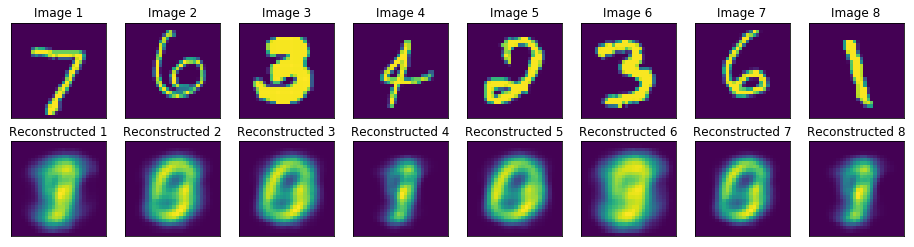

-------------------------------------------------------------------
[epoch 1], [test bce loss 18753.1061 +/- 992.4276], [test kld loss 362.0227 +/- 74.7559], [testing time 2.30]
-------------------------------------------------------------------


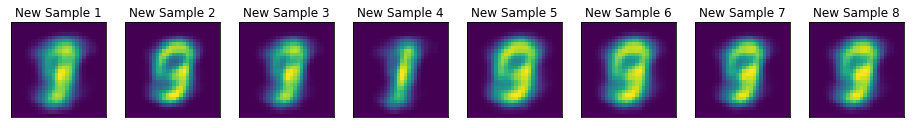

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 2], [train bce loss 17853.3640 +/- 828.1000], [train kld loss 445.4850 +/- 86.6515], [training time 10.55]
-------------------------------------------------------------------


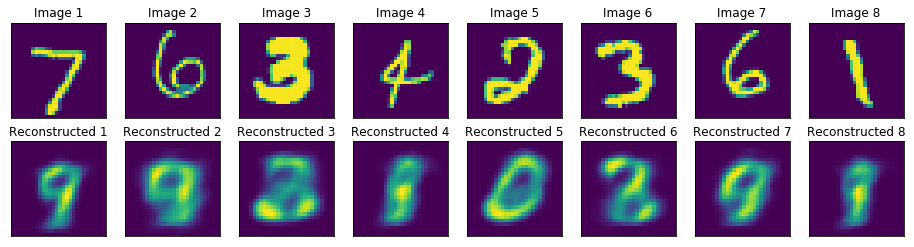

-------------------------------------------------------------------
[epoch 2], [test bce loss 16592.3788 +/- 825.9722], [test kld loss 575.7664 +/- 83.2237], [testing time 2.34]
-------------------------------------------------------------------


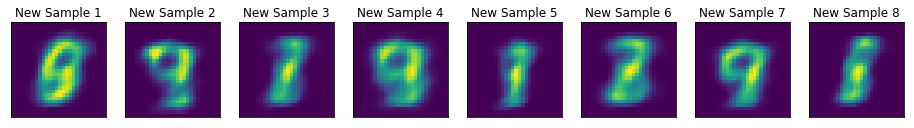

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 3], [train bce loss 15802.1386 +/- 721.2574], [train kld loss 651.0211 +/- 83.4182], [training time 10.62]
-------------------------------------------------------------------


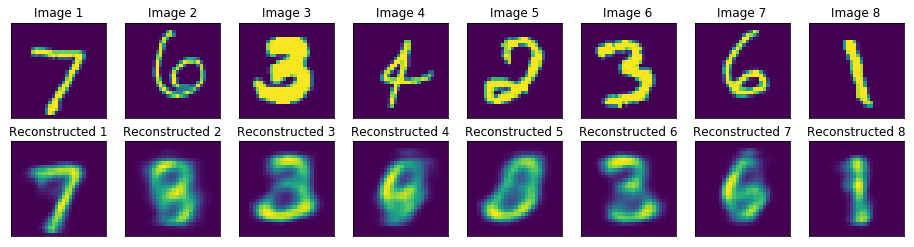

-------------------------------------------------------------------
[epoch 3], [test bce loss 14758.4479 +/- 734.8284], [test kld loss 790.9489 +/- 85.7746], [testing time 2.31]
-------------------------------------------------------------------


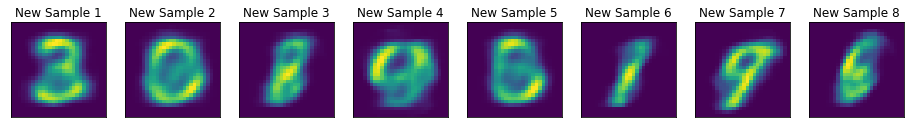

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 4], [train bce loss 14236.9735 +/- 568.0357], [train kld loss 823.3786 +/- 32.8644], [training time 10.64]
-------------------------------------------------------------------


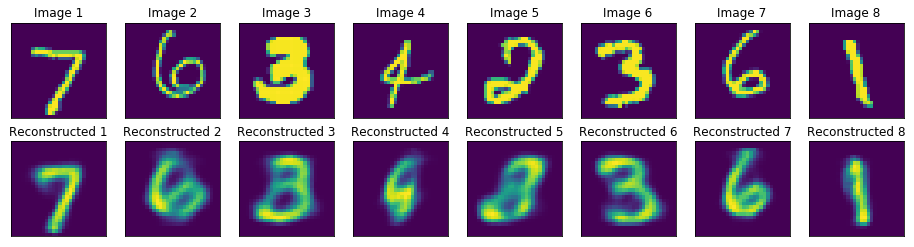

-------------------------------------------------------------------
[epoch 4], [test bce loss 13663.9019 +/- 698.5434], [test kld loss 846.4193 +/- 77.6404], [testing time 2.32]
-------------------------------------------------------------------


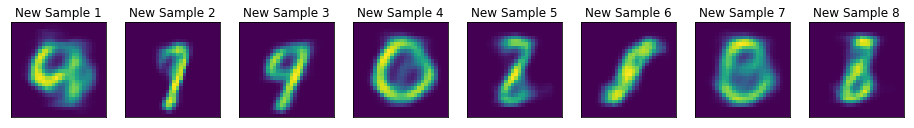

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 5], [train bce loss 13299.3449 +/- 521.0949], [train kld loss 907.9493 +/- 48.5729], [training time 10.66]
-------------------------------------------------------------------


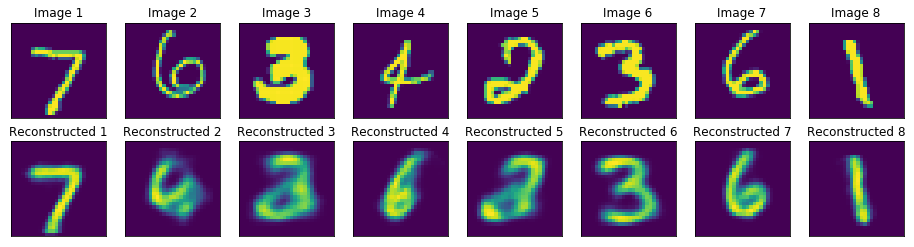

-------------------------------------------------------------------
[epoch 5], [test bce loss 12793.6252 +/- 687.9913], [test kld loss 974.8370 +/- 73.9237], [testing time 2.30]
-------------------------------------------------------------------


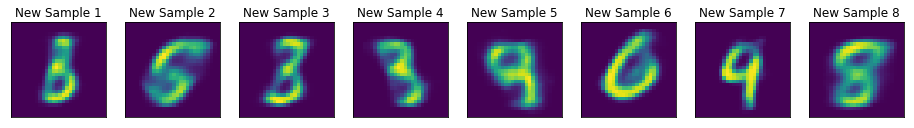

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 6], [train bce loss 12570.7850 +/- 438.5783], [train kld loss 1010.1928 +/- 29.4141], [training time 11.10]
-------------------------------------------------------------------


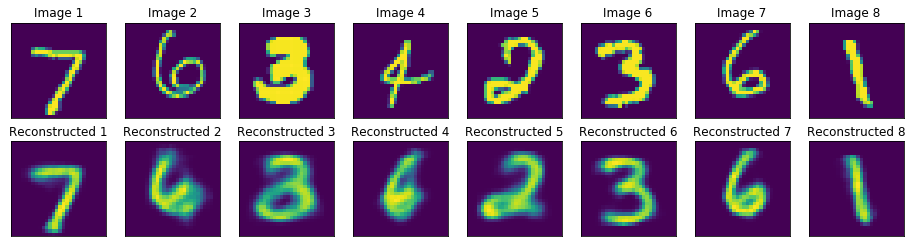

-------------------------------------------------------------------
[epoch 6], [test bce loss 12215.7385 +/- 636.9340], [test kld loss 1072.1771 +/- 59.9363], [testing time 2.41]
-------------------------------------------------------------------


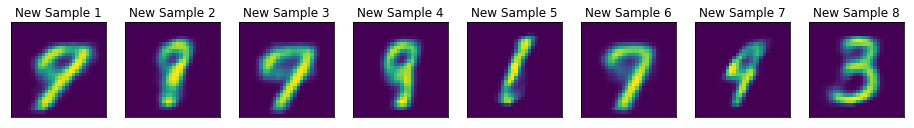

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 7], [train bce loss 12036.5447 +/- 427.2052], [train kld loss 1074.6348 +/- 41.0484], [training time 10.60]
-------------------------------------------------------------------


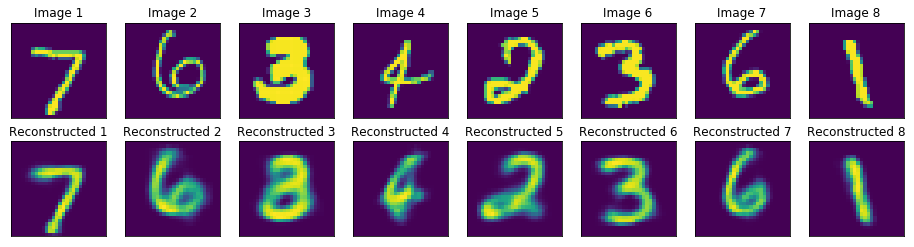

-------------------------------------------------------------------
[epoch 7], [test bce loss 11641.6695 +/- 592.5284], [test kld loss 1143.9322 +/- 69.9582], [testing time 2.38]
-------------------------------------------------------------------


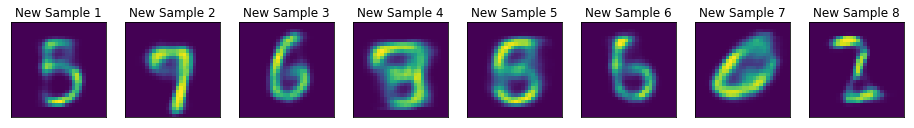

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 8], [train bce loss 11473.4457 +/- 411.6596], [train kld loss 1188.9515 +/- 29.7672], [training time 10.65]
-------------------------------------------------------------------


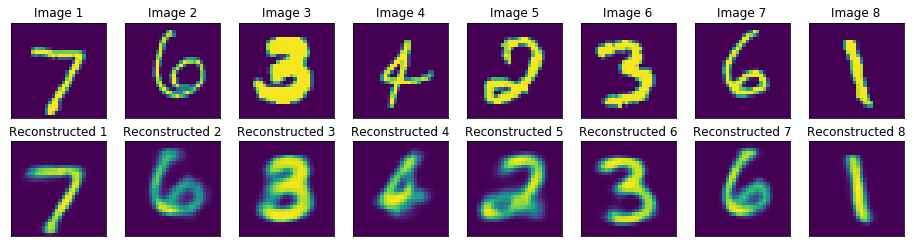

-------------------------------------------------------------------
[epoch 8], [test bce loss 11236.2690 +/- 583.5022], [test kld loss 1210.8699 +/- 54.9861], [testing time 2.38]
-------------------------------------------------------------------


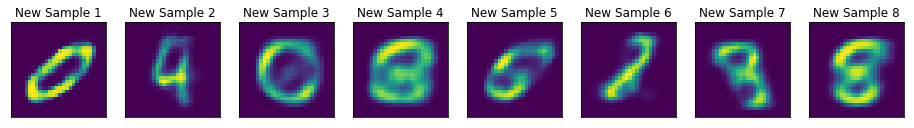

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 9], [train bce loss 11154.9825 +/- 403.5890], [train kld loss 1219.0344 +/- 22.1921], [training time 10.64]
-------------------------------------------------------------------


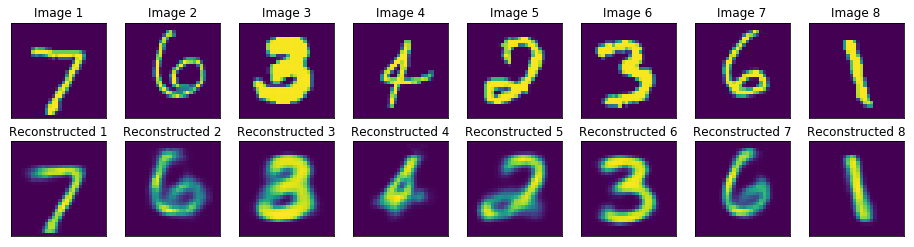

-------------------------------------------------------------------
[epoch 9], [test bce loss 11010.3016 +/- 596.1374], [test kld loss 1232.2808 +/- 49.7478], [testing time 2.36]
-------------------------------------------------------------------


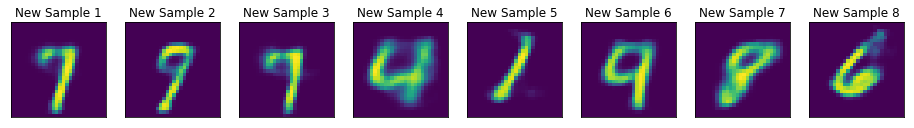

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 10], [train bce loss 10970.1668 +/- 383.5695], [train kld loss 1233.9503 +/- 21.9340], [training time 10.53]
-------------------------------------------------------------------


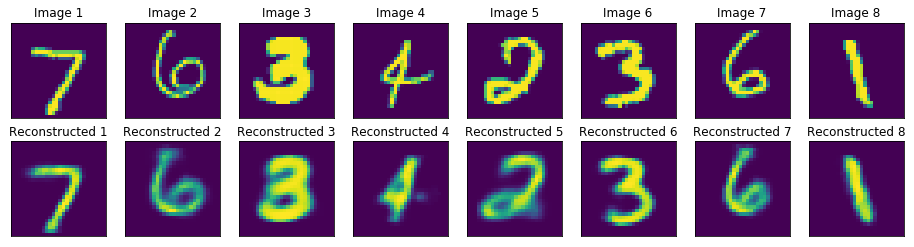

-------------------------------------------------------------------
[epoch 10], [test bce loss 10834.0180 +/- 587.4904], [test kld loss 1249.8866 +/- 49.7827], [testing time 2.42]
-------------------------------------------------------------------


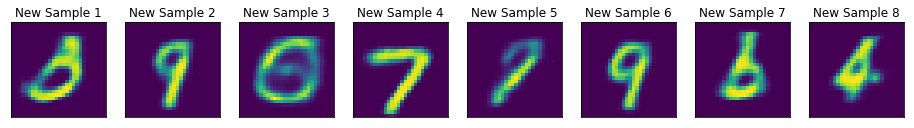

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 11], [train bce loss 10822.1025 +/- 396.5956], [train kld loss 1247.8553 +/- 22.2735], [training time 10.63]
-------------------------------------------------------------------


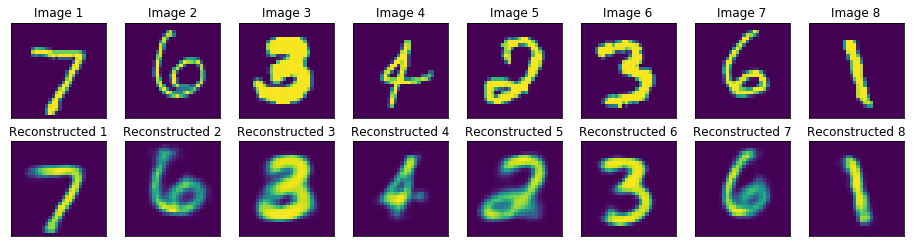

-------------------------------------------------------------------
[epoch 11], [test bce loss 10704.0925 +/- 586.1593], [test kld loss 1272.4525 +/- 46.4694], [testing time 2.30]
-------------------------------------------------------------------


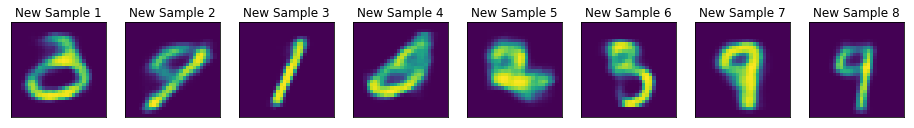

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 12], [train bce loss 10693.7392 +/- 371.3522], [train kld loss 1264.4918 +/- 22.8903], [training time 10.69]
-------------------------------------------------------------------


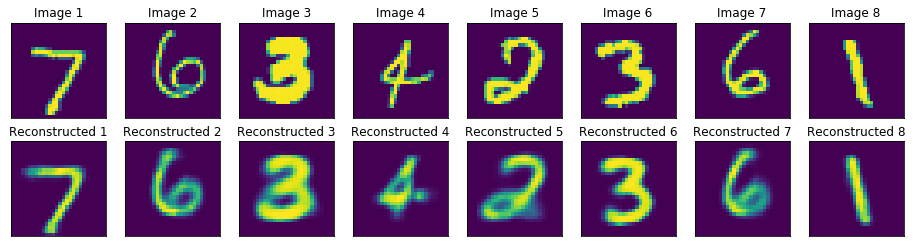

-------------------------------------------------------------------
[epoch 12], [test bce loss 10610.7456 +/- 591.9388], [test kld loss 1275.7233 +/- 45.1176], [testing time 2.31]
-------------------------------------------------------------------


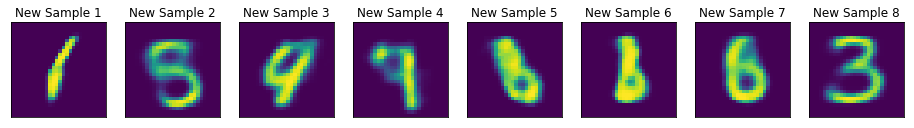

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 13], [train bce loss 10523.0505 +/- 369.7008], [train kld loss 1307.7277 +/- 26.0790], [training time 10.48]
-------------------------------------------------------------------


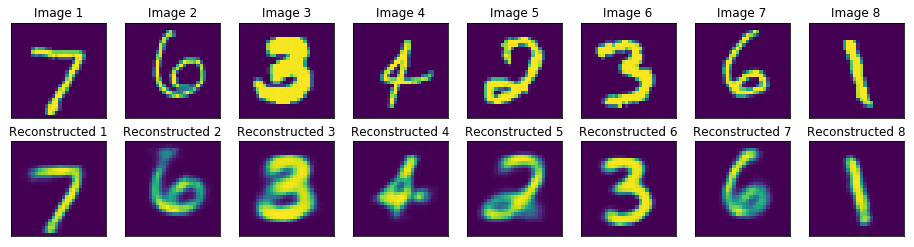

-------------------------------------------------------------------
[epoch 13], [test bce loss 10400.0195 +/- 583.7063], [test kld loss 1332.8106 +/- 48.1370], [testing time 2.26]
-------------------------------------------------------------------


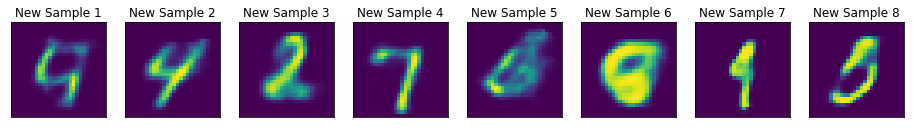

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 14], [train bce loss 10373.3531 +/- 364.5554], [train kld loss 1341.5388 +/- 25.3927], [training time 10.61]
-------------------------------------------------------------------


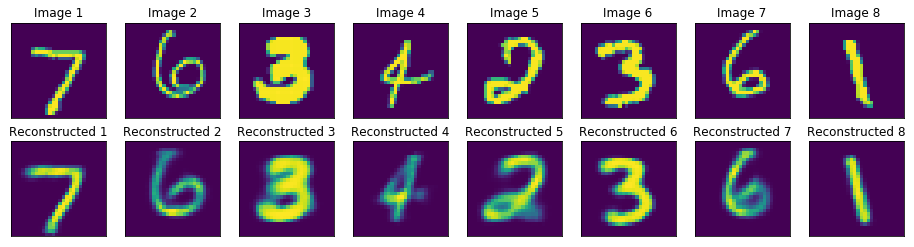

-------------------------------------------------------------------
[epoch 14], [test bce loss 10274.9999 +/- 578.1586], [test kld loss 1378.9448 +/- 48.3086], [testing time 2.35]
-------------------------------------------------------------------


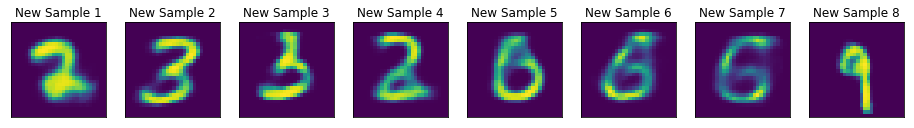

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 15], [train bce loss 10243.3965 +/- 347.9231], [train kld loss 1368.4333 +/- 24.9981], [training time 10.69]
-------------------------------------------------------------------


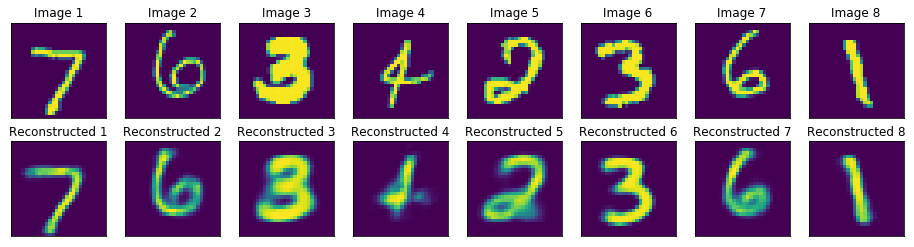

-------------------------------------------------------------------
[epoch 15], [test bce loss 10188.8118 +/- 581.8971], [test kld loss 1362.0529 +/- 42.5184], [testing time 2.30]
-------------------------------------------------------------------


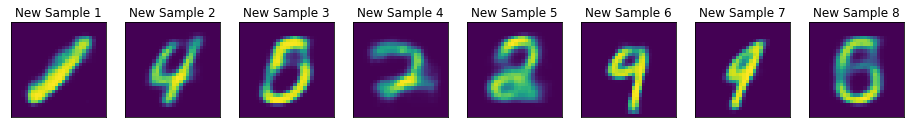

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 16], [train bce loss 10119.3162 +/- 353.8520], [train kld loss 1386.4848 +/- 24.5374], [training time 10.52]
-------------------------------------------------------------------


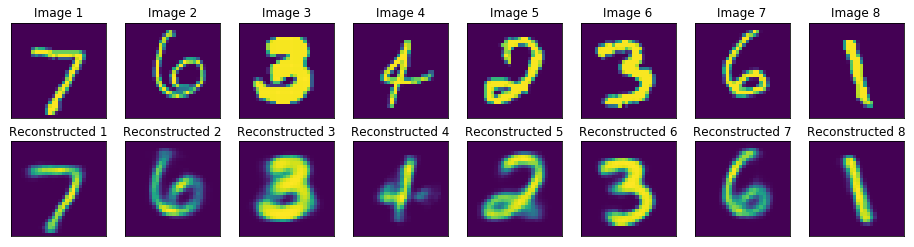

-------------------------------------------------------------------
[epoch 16], [test bce loss 10015.0637 +/- 583.9003], [test kld loss 1409.6468 +/- 46.5923], [testing time 2.31]
-------------------------------------------------------------------


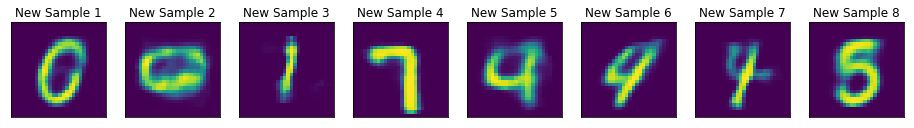

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 17], [train bce loss 10014.9505 +/- 343.9544], [train kld loss 1400.1208 +/- 23.6031], [training time 11.01]
-------------------------------------------------------------------


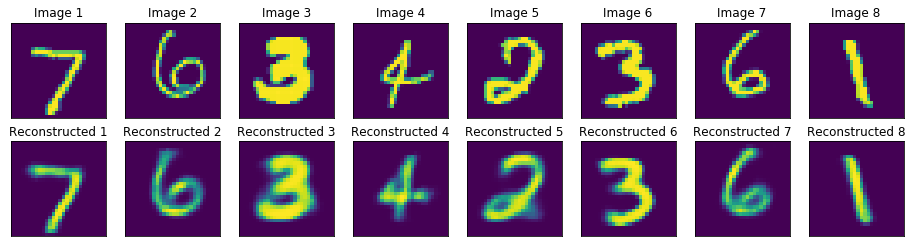

-------------------------------------------------------------------
[epoch 17], [test bce loss 9947.0948 +/- 585.4010], [test kld loss 1426.2630 +/- 45.8777], [testing time 2.69]
-------------------------------------------------------------------


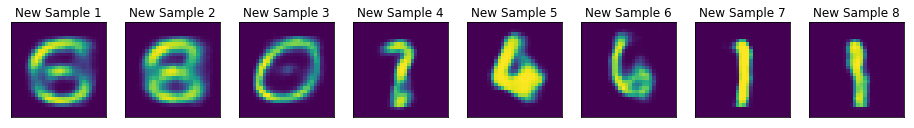

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 18], [train bce loss 9934.3141 +/- 365.4113], [train kld loss 1409.5498 +/- 25.0928], [training time 10.56]
-------------------------------------------------------------------


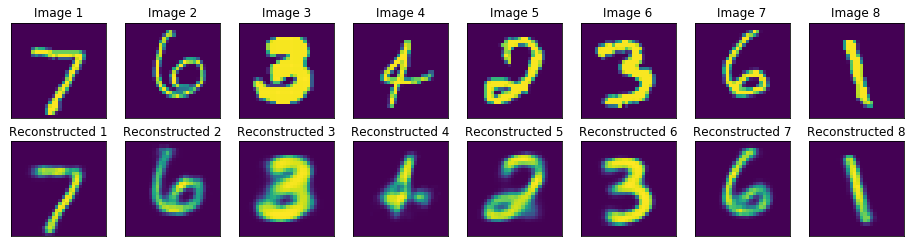

-------------------------------------------------------------------
[epoch 18], [test bce loss 9935.3826 +/- 592.6298], [test kld loss 1403.6326 +/- 45.7222], [testing time 2.30]
-------------------------------------------------------------------


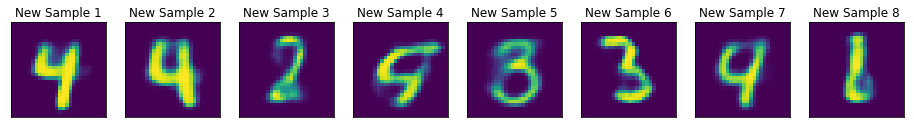

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 19], [train bce loss 9863.8938 +/- 346.0815], [train kld loss 1420.0719 +/- 23.3230], [training time 10.62]
-------------------------------------------------------------------


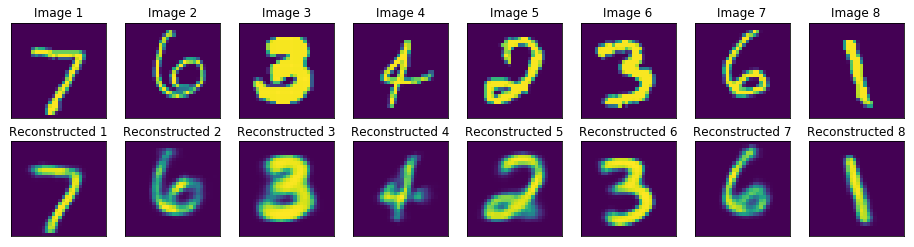

-------------------------------------------------------------------
[epoch 19], [test bce loss 9857.3183 +/- 581.1407], [test kld loss 1419.9056 +/- 41.3680], [testing time 2.44]
-------------------------------------------------------------------


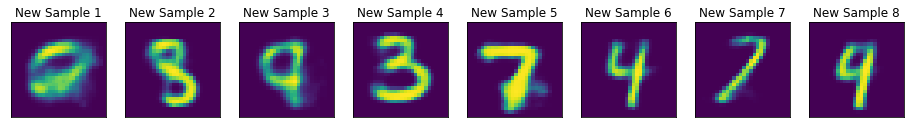

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 20], [train bce loss 9801.6166 +/- 350.9586], [train kld loss 1428.2054 +/- 23.6377], [training time 10.60]
-------------------------------------------------------------------


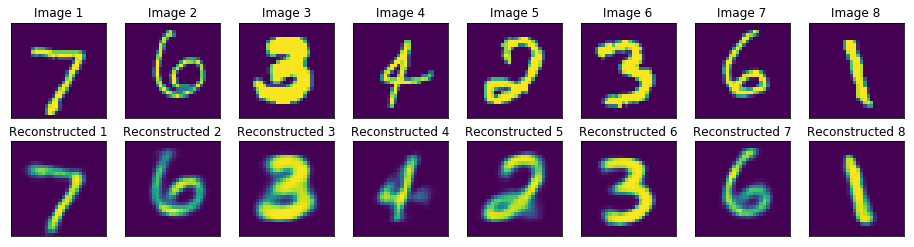

-------------------------------------------------------------------
[epoch 20], [test bce loss 9783.4434 +/- 584.1509], [test kld loss 1432.7649 +/- 43.2123], [testing time 2.29]
-------------------------------------------------------------------


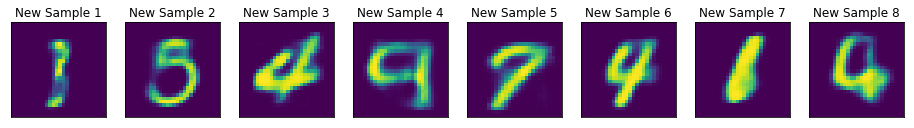

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 21], [train bce loss 9748.2673 +/- 358.9878], [train kld loss 1435.6168 +/- 24.6070], [training time 10.94]
-------------------------------------------------------------------


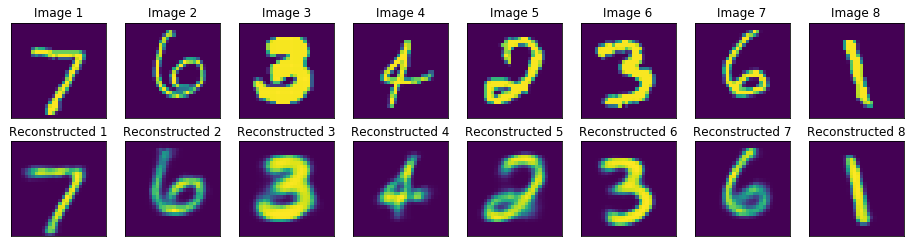

-------------------------------------------------------------------
[epoch 21], [test bce loss 9718.4222 +/- 583.5645], [test kld loss 1454.2425 +/- 41.4009], [testing time 2.44]
-------------------------------------------------------------------


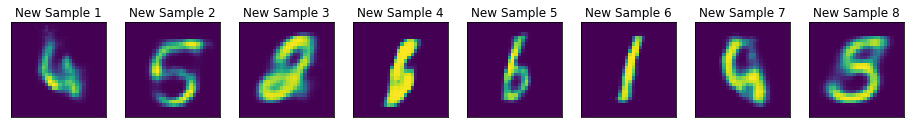

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 22], [train bce loss 9690.1289 +/- 339.9577], [train kld loss 1447.5412 +/- 23.6257], [training time 10.81]
-------------------------------------------------------------------


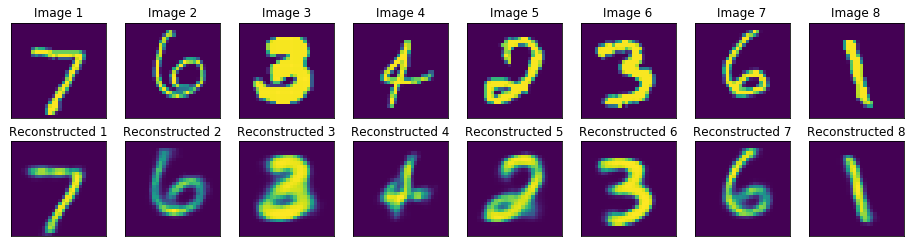

-------------------------------------------------------------------
[epoch 22], [test bce loss 9719.3088 +/- 582.6293], [test kld loss 1433.3650 +/- 38.2243], [testing time 2.39]
-------------------------------------------------------------------


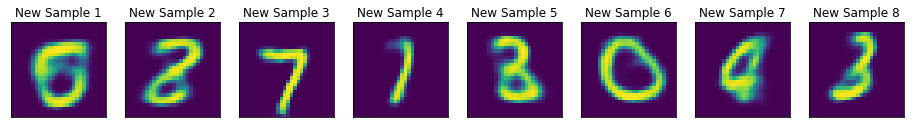

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 23], [train bce loss 9615.4910 +/- 322.9346], [train kld loss 1467.2070 +/- 24.2009], [training time 10.75]
-------------------------------------------------------------------


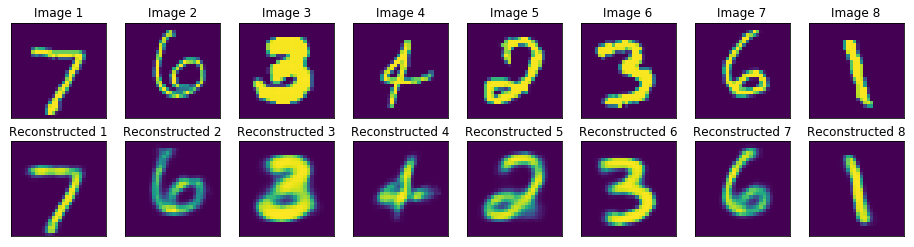

-------------------------------------------------------------------
[epoch 23], [test bce loss 9623.7562 +/- 585.2333], [test kld loss 1475.0270 +/- 43.3296], [testing time 2.32]
-------------------------------------------------------------------


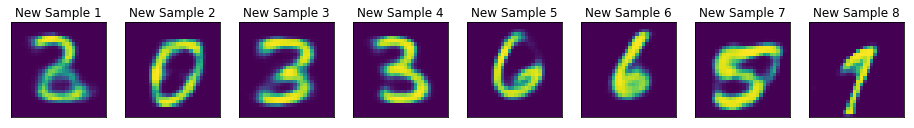

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 24], [train bce loss 9544.7511 +/- 337.5644], [train kld loss 1488.0452 +/- 27.5507], [training time 10.79]
-------------------------------------------------------------------


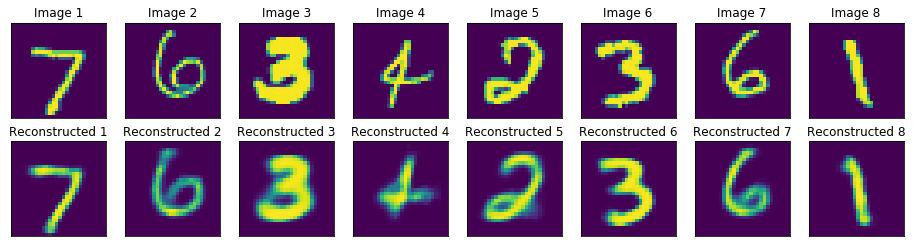

-------------------------------------------------------------------
[epoch 24], [test bce loss 9563.8354 +/- 575.9206], [test kld loss 1496.6117 +/- 41.0410], [testing time 2.31]
-------------------------------------------------------------------


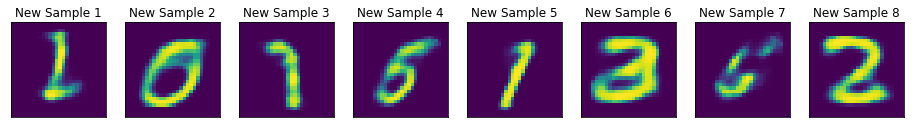

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 25], [train bce loss 9474.3908 +/- 323.9820], [train kld loss 1505.2373 +/- 26.6561], [training time 10.92]
-------------------------------------------------------------------


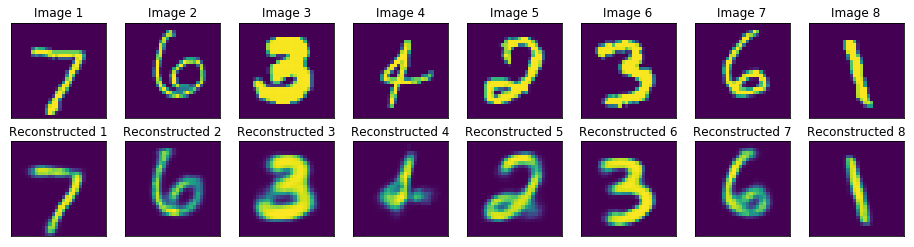

-------------------------------------------------------------------
[epoch 25], [test bce loss 9519.0381 +/- 577.3500], [test kld loss 1499.3476 +/- 38.6304], [testing time 2.34]
-------------------------------------------------------------------


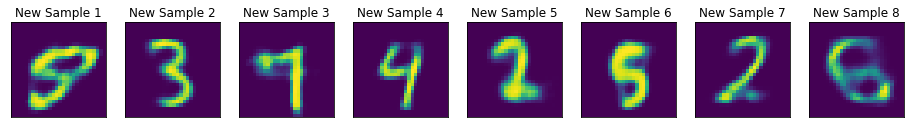

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 26], [train bce loss 9403.9102 +/- 320.4234], [train kld loss 1523.2892 +/- 27.1836], [training time 10.94]
-------------------------------------------------------------------


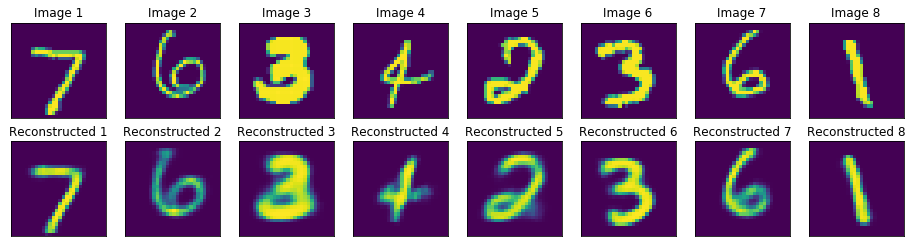

-------------------------------------------------------------------
[epoch 26], [test bce loss 9418.4871 +/- 581.1950], [test kld loss 1544.5366 +/- 41.8842], [testing time 2.34]
-------------------------------------------------------------------


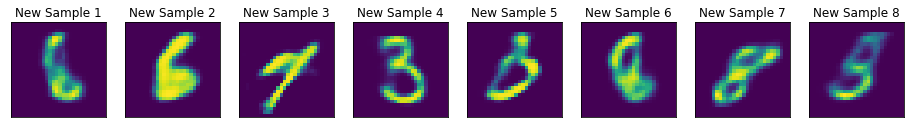

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 27], [train bce loss 9341.7826 +/- 331.6813], [train kld loss 1534.9193 +/- 26.3289], [training time 10.78]
-------------------------------------------------------------------


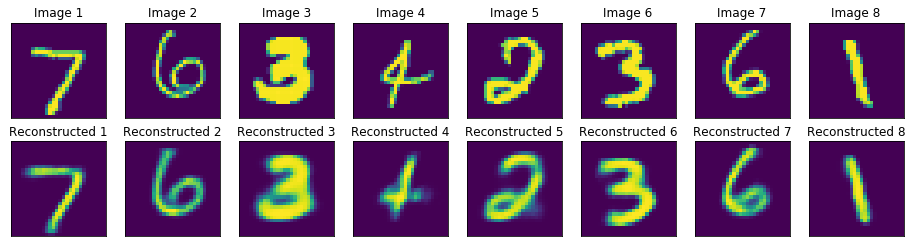

-------------------------------------------------------------------
[epoch 27], [test bce loss 9408.8911 +/- 582.2873], [test kld loss 1513.0590 +/- 40.6862], [testing time 2.46]
-------------------------------------------------------------------


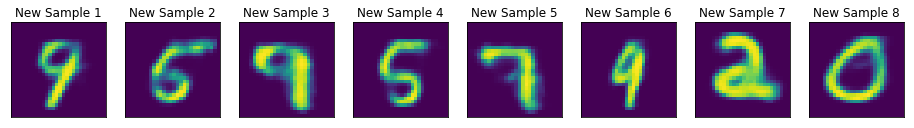

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 28], [train bce loss 9292.0731 +/- 306.6141], [train kld loss 1545.5024 +/- 27.5517], [training time 11.00]
-------------------------------------------------------------------


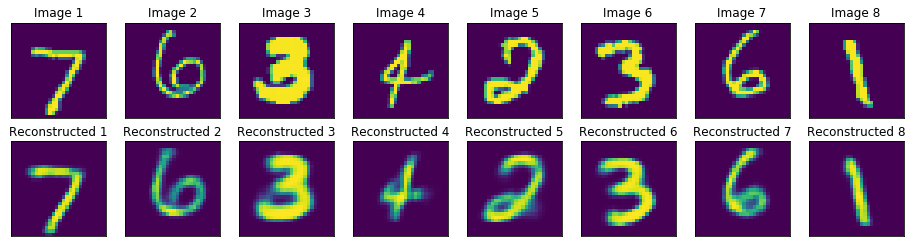

-------------------------------------------------------------------
[epoch 28], [test bce loss 9329.3742 +/- 566.8549], [test kld loss 1559.5517 +/- 42.8183], [testing time 2.40]
-------------------------------------------------------------------


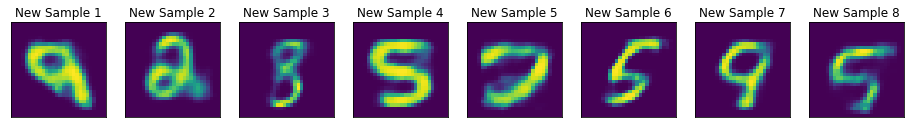

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 29], [train bce loss 9245.3964 +/- 328.1798], [train kld loss 1554.1118 +/- 26.0965], [training time 10.87]
-------------------------------------------------------------------


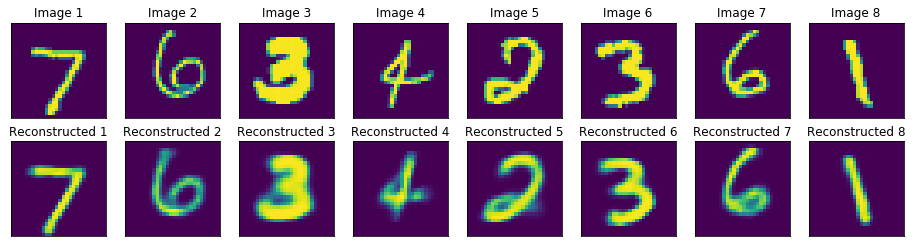

-------------------------------------------------------------------
[epoch 29], [test bce loss 9302.6327 +/- 572.6977], [test kld loss 1556.2297 +/- 43.2316], [testing time 2.32]
-------------------------------------------------------------------


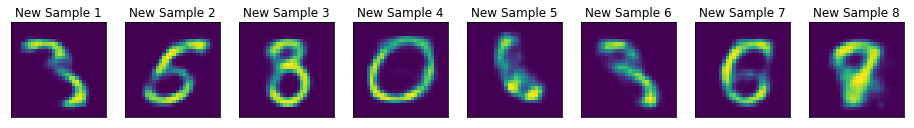

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 30], [train bce loss 9207.9643 +/- 339.5981], [train kld loss 1559.7861 +/- 27.5905], [training time 10.77]
-------------------------------------------------------------------


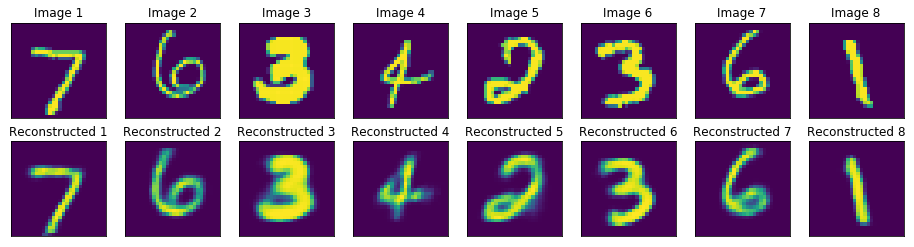

-------------------------------------------------------------------
[epoch 30], [test bce loss 9286.8648 +/- 570.5680], [test kld loss 1538.9008 +/- 42.7134], [testing time 2.49]
-------------------------------------------------------------------


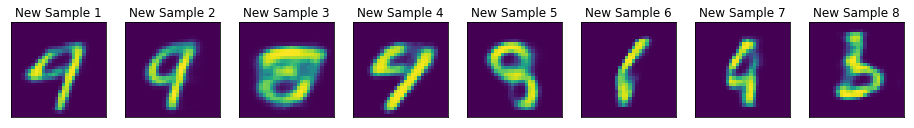

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 31], [train bce loss 9171.6122 +/- 319.1579], [train kld loss 1566.2855 +/- 26.0960], [training time 10.78]
-------------------------------------------------------------------


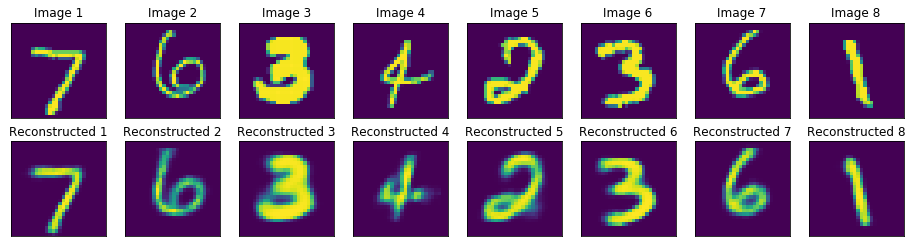

-------------------------------------------------------------------
[epoch 31], [test bce loss 9230.6987 +/- 564.3902], [test kld loss 1571.8731 +/- 42.9376], [testing time 2.37]
-------------------------------------------------------------------


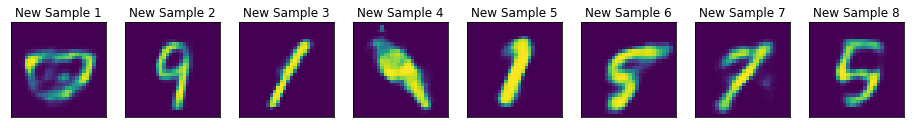

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 32], [train bce loss 9143.7301 +/- 318.0397], [train kld loss 1570.9121 +/- 27.5399], [training time 10.89]
-------------------------------------------------------------------


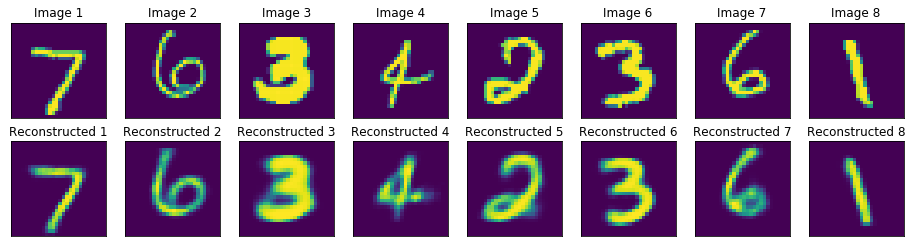

-------------------------------------------------------------------
[epoch 32], [test bce loss 9201.6271 +/- 558.4729], [test kld loss 1588.5088 +/- 47.3903], [testing time 2.52]
-------------------------------------------------------------------


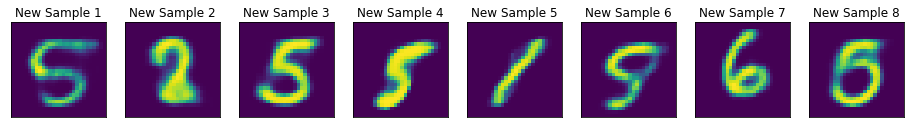

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 33], [train bce loss 9110.7370 +/- 312.4901], [train kld loss 1574.3307 +/- 26.8726], [training time 10.75]
-------------------------------------------------------------------


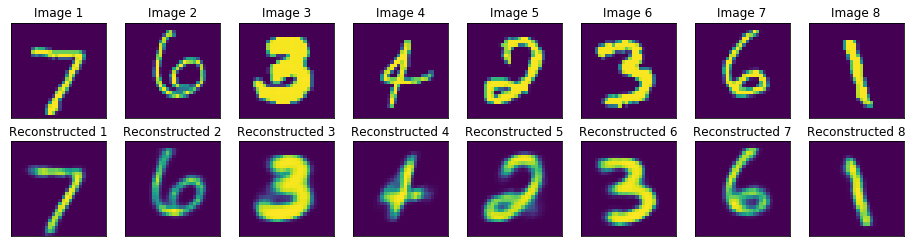

-------------------------------------------------------------------
[epoch 33], [test bce loss 9212.4087 +/- 569.4471], [test kld loss 1560.0738 +/- 44.5097], [testing time 2.29]
-------------------------------------------------------------------


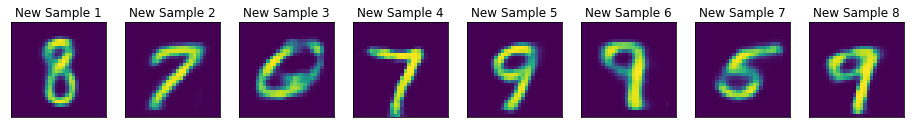

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 34], [train bce loss 9084.8951 +/- 331.9992], [train kld loss 1579.3426 +/- 28.2310], [training time 10.92]
-------------------------------------------------------------------


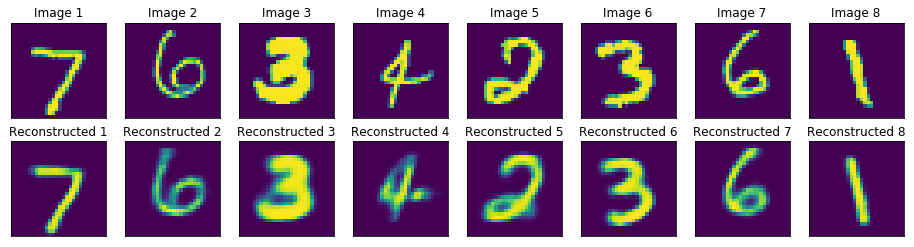

-------------------------------------------------------------------
[epoch 34], [test bce loss 9171.3019 +/- 567.6592], [test kld loss 1577.5580 +/- 43.0772], [testing time 2.34]
-------------------------------------------------------------------


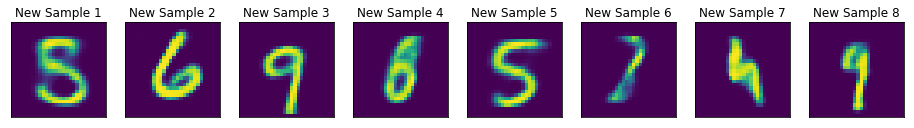

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 35], [train bce loss 9057.0242 +/- 319.2021], [train kld loss 1583.7077 +/- 27.8898], [training time 10.69]
-------------------------------------------------------------------


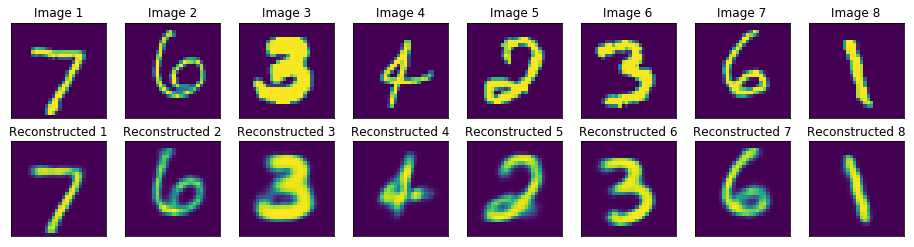

-------------------------------------------------------------------
[epoch 35], [test bce loss 9168.2527 +/- 561.0817], [test kld loss 1564.5372 +/- 39.1584], [testing time 2.30]
-------------------------------------------------------------------


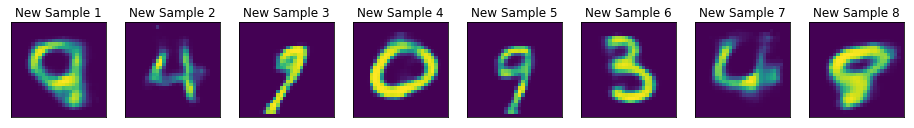

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 36], [train bce loss 9034.6076 +/- 315.3206], [train kld loss 1587.2527 +/- 28.2795], [training time 10.79]
-------------------------------------------------------------------


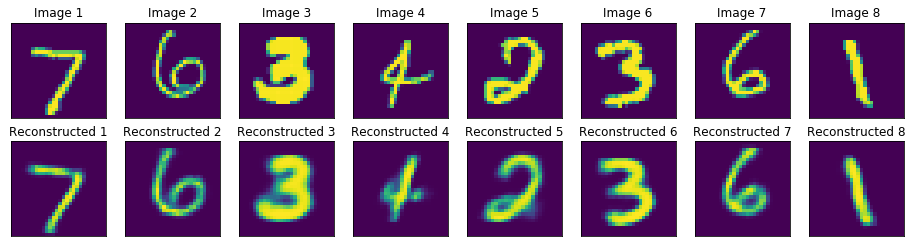

-------------------------------------------------------------------
[epoch 36], [test bce loss 9168.3667 +/- 566.8615], [test kld loss 1590.2485 +/- 42.5423], [testing time 2.27]
-------------------------------------------------------------------


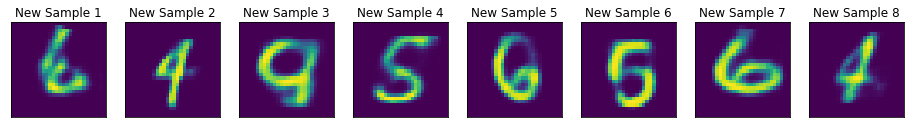

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 37], [train bce loss 9011.5899 +/- 326.4993], [train kld loss 1591.2784 +/- 27.0777], [training time 10.74]
-------------------------------------------------------------------


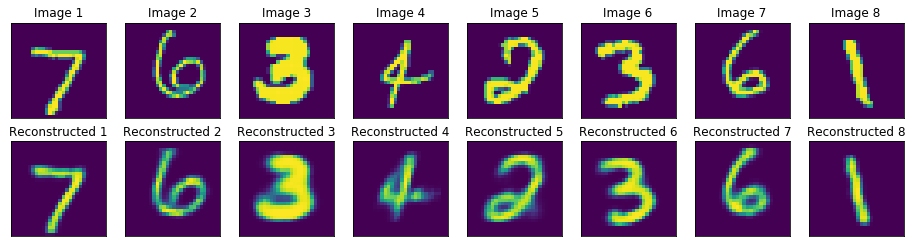

-------------------------------------------------------------------
[epoch 37], [test bce loss 9143.2301 +/- 572.8151], [test kld loss 1571.2670 +/- 42.9857], [testing time 2.40]
-------------------------------------------------------------------


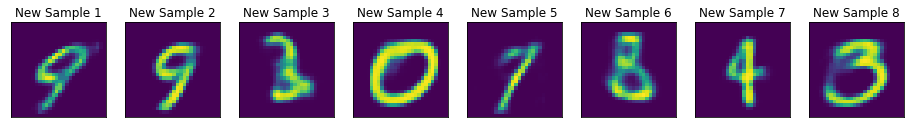

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 38], [train bce loss 8991.2301 +/- 310.7377], [train kld loss 1593.9805 +/- 27.3727], [training time 10.78]
-------------------------------------------------------------------


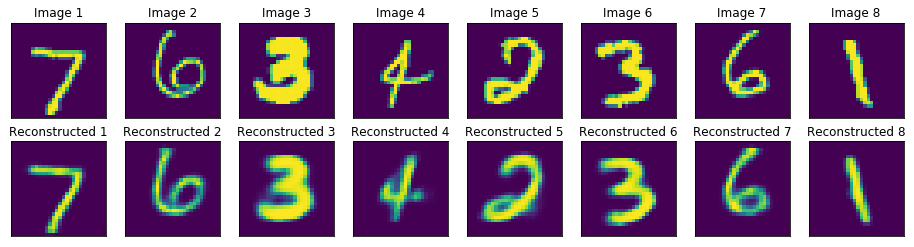

-------------------------------------------------------------------
[epoch 38], [test bce loss 9112.3897 +/- 568.2574], [test kld loss 1591.0977 +/- 43.1665], [testing time 2.34]
-------------------------------------------------------------------


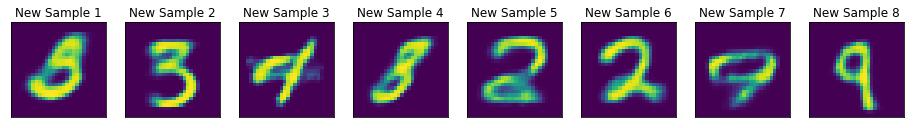

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 39], [train bce loss 8969.8026 +/- 305.3149], [train kld loss 1597.6952 +/- 26.5638], [training time 11.25]
-------------------------------------------------------------------


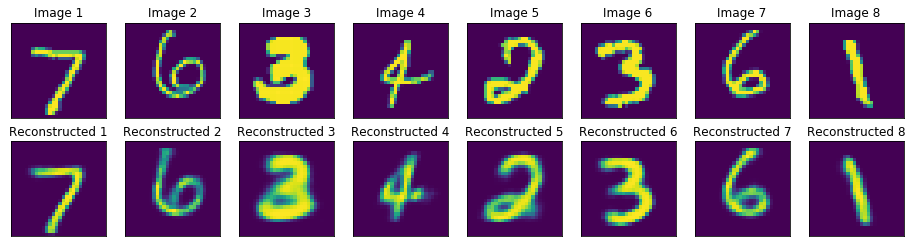

-------------------------------------------------------------------
[epoch 39], [test bce loss 9064.7477 +/- 562.4576], [test kld loss 1611.1276 +/- 42.2526], [testing time 2.81]
-------------------------------------------------------------------


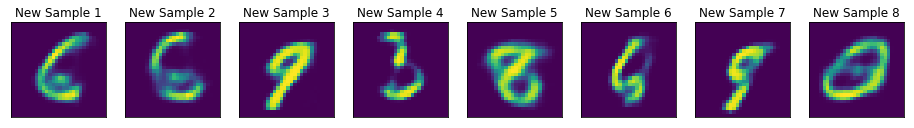

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 40], [train bce loss 8951.0656 +/- 315.5407], [train kld loss 1600.9616 +/- 26.5797], [training time 10.97]
-------------------------------------------------------------------


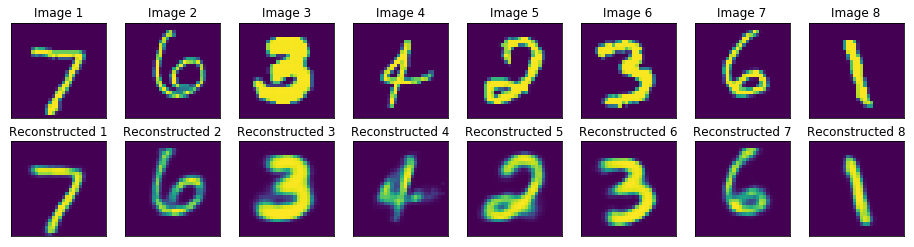

-------------------------------------------------------------------
[epoch 40], [test bce loss 9085.2456 +/- 570.7595], [test kld loss 1582.5820 +/- 42.0845], [testing time 2.34]
-------------------------------------------------------------------


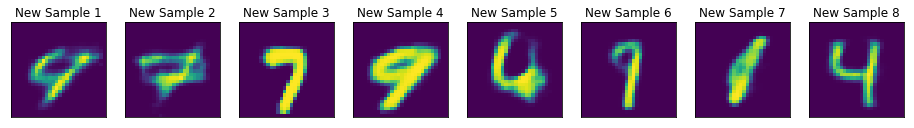

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 41], [train bce loss 8932.8275 +/- 328.9761], [train kld loss 1602.9287 +/- 26.4312], [training time 10.68]
-------------------------------------------------------------------


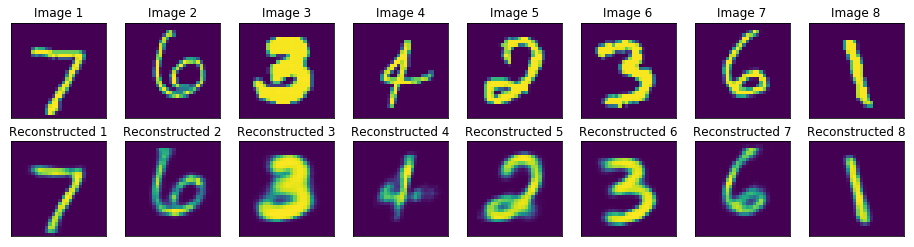

-------------------------------------------------------------------
[epoch 41], [test bce loss 9065.7963 +/- 557.1040], [test kld loss 1589.9093 +/- 41.8044], [testing time 2.46]
-------------------------------------------------------------------


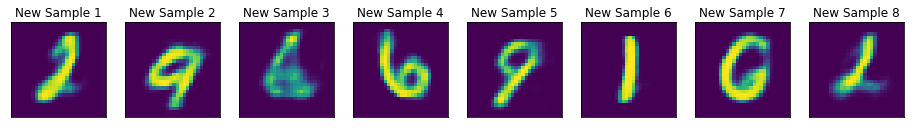

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 42], [train bce loss 8916.4487 +/- 315.0437], [train kld loss 1604.7624 +/- 27.2878], [training time 10.73]
-------------------------------------------------------------------


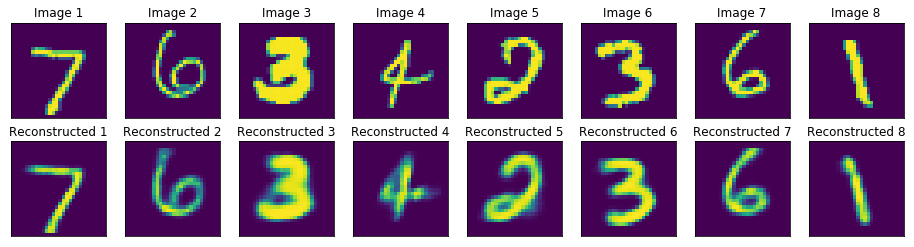

-------------------------------------------------------------------
[epoch 42], [test bce loss 9066.0183 +/- 562.8774], [test kld loss 1590.7139 +/- 47.2281], [testing time 2.33]
-------------------------------------------------------------------


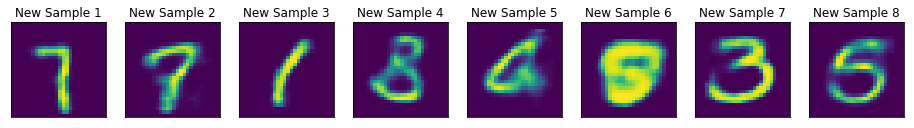

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 43], [train bce loss 8900.3682 +/- 307.4700], [train kld loss 1608.4628 +/- 27.5712], [training time 10.71]
-------------------------------------------------------------------


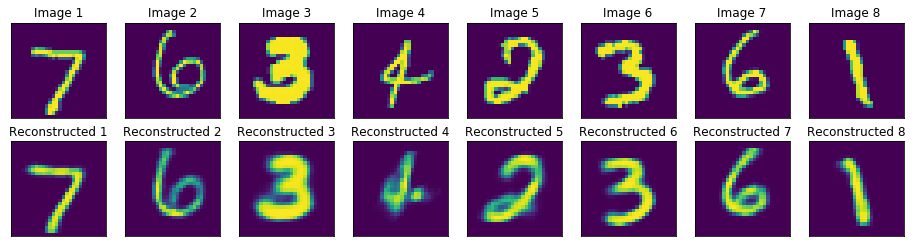

-------------------------------------------------------------------
[epoch 43], [test bce loss 9028.9233 +/- 578.9695], [test kld loss 1618.2127 +/- 43.5751], [testing time 2.52]
-------------------------------------------------------------------


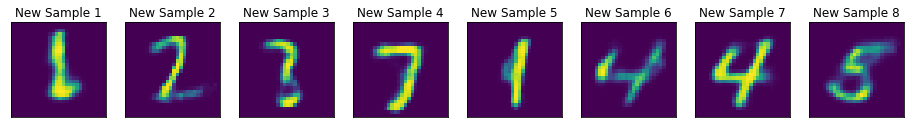

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 44], [train bce loss 8882.4192 +/- 290.0209], [train kld loss 1611.2092 +/- 25.9228], [training time 10.64]
-------------------------------------------------------------------


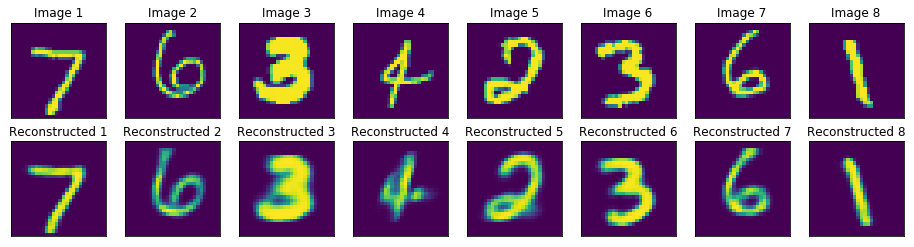

-------------------------------------------------------------------
[epoch 44], [test bce loss 9038.4991 +/- 571.7963], [test kld loss 1591.7963 +/- 42.2888], [testing time 2.29]
-------------------------------------------------------------------


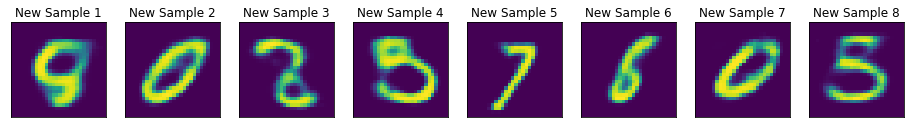

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 45], [train bce loss 8866.9674 +/- 311.1135], [train kld loss 1612.4959 +/- 27.0710], [training time 10.76]
-------------------------------------------------------------------


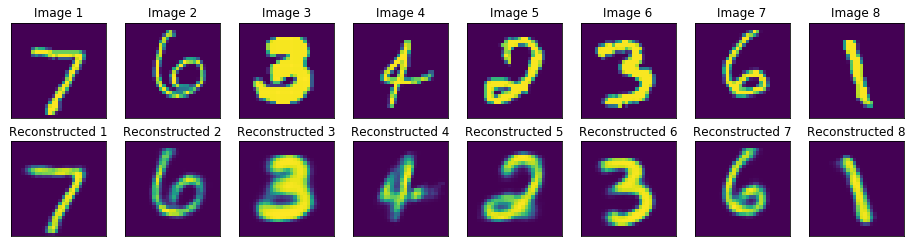

-------------------------------------------------------------------
[epoch 45], [test bce loss 8999.8818 +/- 566.6986], [test kld loss 1621.7822 +/- 43.6287], [testing time 2.34]
-------------------------------------------------------------------


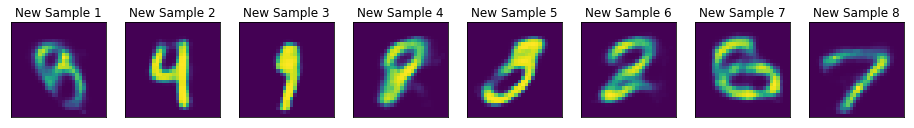

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 46], [train bce loss 8854.7445 +/- 305.3329], [train kld loss 1614.2444 +/- 28.3967], [training time 10.66]
-------------------------------------------------------------------


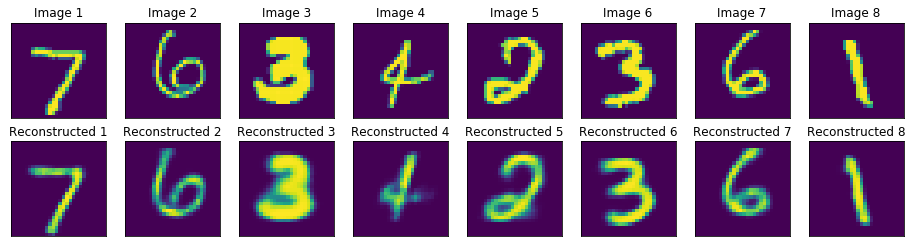

-------------------------------------------------------------------
[epoch 46], [test bce loss 9000.0818 +/- 564.4953], [test kld loss 1625.0487 +/- 40.5683], [testing time 2.39]
-------------------------------------------------------------------


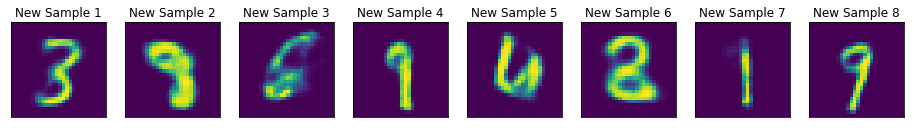

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 47], [train bce loss 8842.1274 +/- 299.1394], [train kld loss 1615.9397 +/- 27.5663], [training time 10.90]
-------------------------------------------------------------------


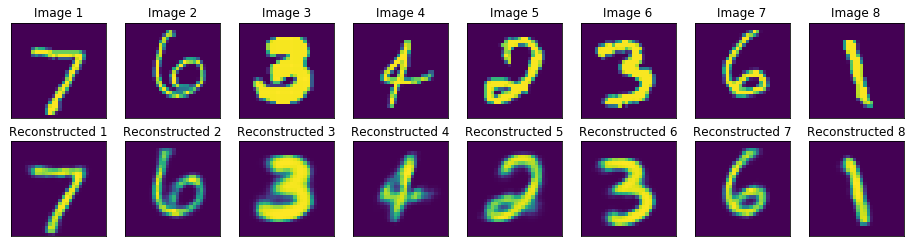

-------------------------------------------------------------------
[epoch 47], [test bce loss 8985.3987 +/- 561.5902], [test kld loss 1624.9686 +/- 39.4663], [testing time 2.33]
-------------------------------------------------------------------


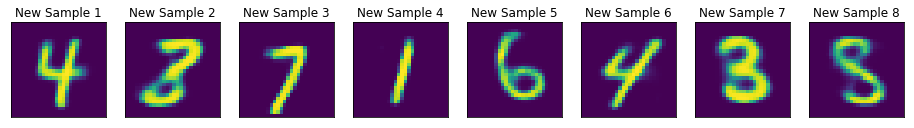

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 48], [train bce loss 8823.7160 +/- 305.8230], [train kld loss 1619.1610 +/- 28.2959], [training time 10.89]
-------------------------------------------------------------------


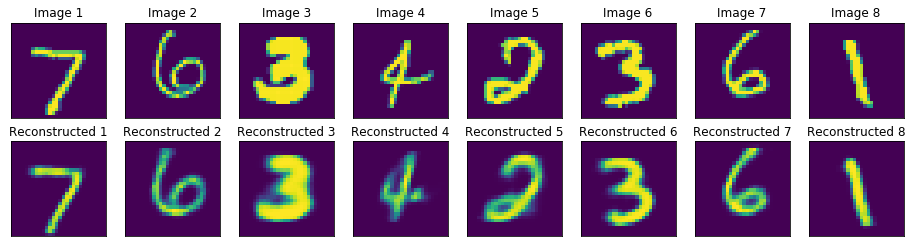

-------------------------------------------------------------------
[epoch 48], [test bce loss 9007.9114 +/- 567.7943], [test kld loss 1607.3569 +/- 45.1578], [testing time 2.36]
-------------------------------------------------------------------


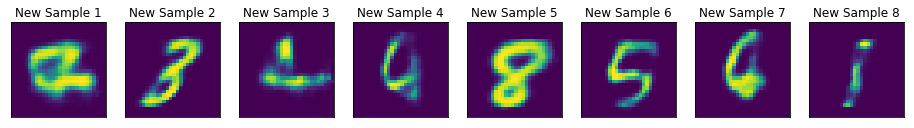

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 49], [train bce loss 8809.5264 +/- 307.1657], [train kld loss 1621.4727 +/- 27.8672], [training time 10.80]
-------------------------------------------------------------------


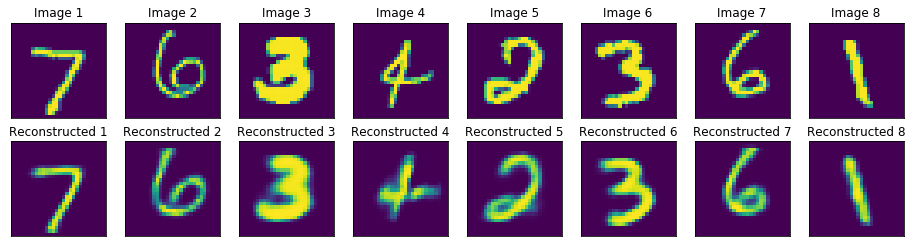

-------------------------------------------------------------------
[epoch 49], [test bce loss 8992.2079 +/- 577.9395], [test kld loss 1615.1017 +/- 42.6986], [testing time 2.31]
-------------------------------------------------------------------


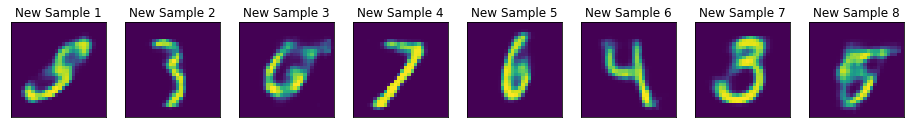

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 50], [train bce loss 8797.2746 +/- 316.2829], [train kld loss 1623.5810 +/- 26.9058], [training time 11.10]
-------------------------------------------------------------------


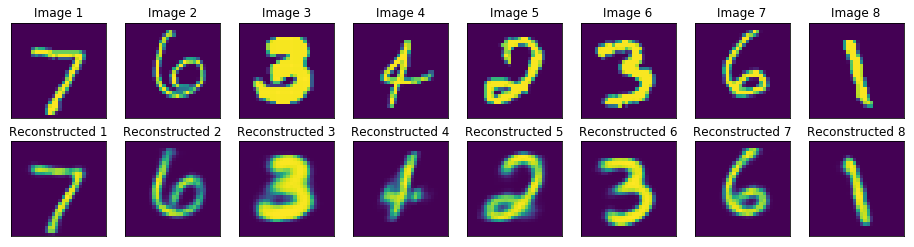

-------------------------------------------------------------------
[epoch 50], [test bce loss 8984.1640 +/- 557.3763], [test kld loss 1598.4376 +/- 40.8036], [testing time 2.80]
-------------------------------------------------------------------


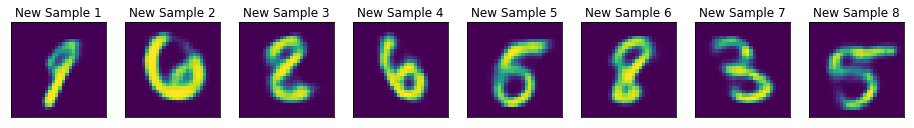

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------


In [21]:
# Iterating over epochs.
for epoch in range(1, args['epoch_num'] + 1):

    # Training function.
    train(train_loader, net, optimizer, epoch)

    # Computing test loss and metrics.
    test(test_loader, net, epoch)
    
    # Evaluating sample generation in VAE.
    evaluate(net, args['num_samples'], args['num_gauss'])
    
    print('-- End of Epoch ---------------------------------------------------')
    print('-------------------------------------------------------------------')

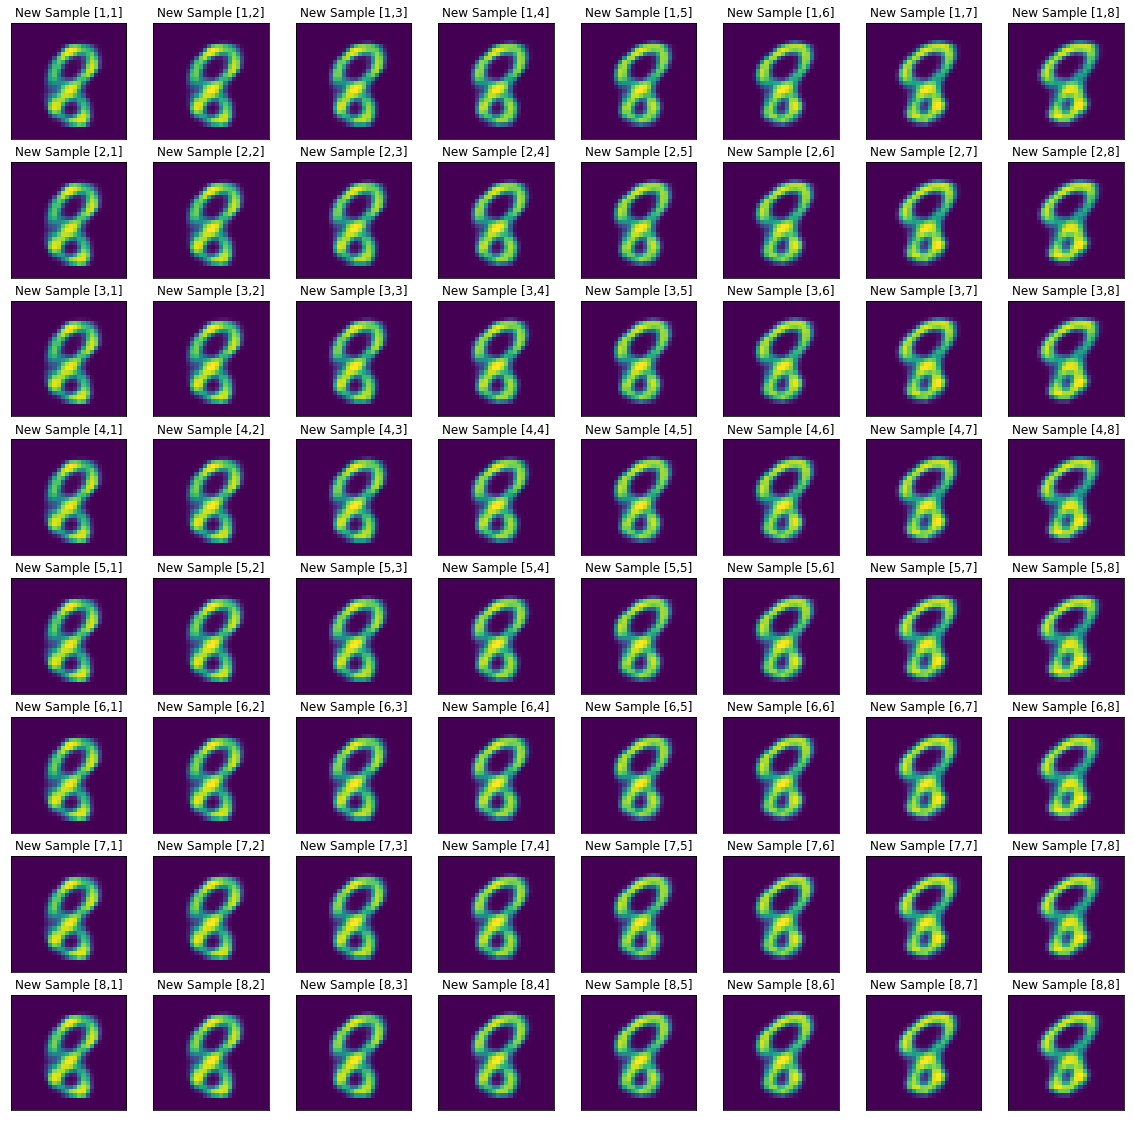

In [11]:
# Evaluation procedure for sample generation.
def generate_2d(net, n_samples, n_gauss):

    # Setting network for evaluation mode.
    net.eval()
    
    # Creating linear space to visualize bivariate gaussian.
    linspace_gauss = torch.linspace(-2.5, 2.5, n_samples)
    
    # Select Gaussian dimensions
    dim_linspace = (0, 1)
    
    # Plotting.
    fig, ax = plt.subplots(n_samples, n_samples, figsize=(20, 20))

    for i in range(n_samples):
        
        for j in range(n_samples):

            # Filling batch with size 1 and n_gauss zeros of dimension.
            sample = torch.zeros(1, n_gauss).to(args['device'])
            
            # Replacing zeros in dimensions dim_linspace with values from
            # variable linspace_gauss.
            sample[0, dim_linspace[0]] = linspace_gauss[j]
            sample[0, dim_linspace[1]] = linspace_gauss[i]

            # Forwarding through decoder.
            sample = net.decode(sample).detach().cpu().view(28, 28).numpy()

            # Printing sample.
            ax[j, i].imshow(sample)
            ax[j, i].set_yticks([])
            ax[j, i].set_xticks([])
            ax[j, i].set_title('New Sample [' + str(j + 1) + ',' + str(i + 1) + ']')
        
    plt.show()
    
    
generate_2d(net, args['num_samples'], args['num_gauss'])